In [1]:
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Description
## 1. accuracy
    - v1 : 순정
        DecisionTree : 0.69
        RandomForest : 0.71
        GradientBoost : 0.69
    - v2 : 변수선택 및 타입조절
        DecisionTree : 
        RandomForest : 
        GradientBoost : 

## data load and wrangling

In [2]:
train = pd.read_csv('./input/235713_신용카드 사용자 연체 예측 AI 경진대회_data/open/train.csv')
test = pd.read_csv('./input/235713_신용카드 사용자 연체 예측 AI 경진대회_data/open/test.csv')
sub = pd.read_csv('./input/235713_신용카드 사용자 연체 예측 AI 경진대회_data/open/sample_submission.csv')

In [3]:
train.shape
# train.isnull().sum()

(26457, 20)

In [4]:
train.nunique()
train.dtypes

# train_x.isnull().sum()

index              int64
gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

### 1. EDA

In [5]:
nm_y = ['credit']
nm_num = ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 
          'work_phone', 'phone', 'email', 'family_size', 'begin_month']
nm_str = train.columns.drop(nm_num)
nm_str

Index(['index', 'gender', 'car', 'reality', 'income_type', 'edu_type',
       'family_type', 'house_type', 'occyp_type', 'credit'],
      dtype='object')

In [6]:
train[nm_str].head(5)
train[nm_str].nunique()

train['car'].value_counts()
# train['income_type'].value_counts()
# train['edu_type'].value_counts()
# train['family_type'].value_counts()
# train['house_type'].value_counts()

test['car'].value_counts()
# test['income_type'].value_counts()
# test['edu_type'].value_counts()
# test['family_type'].value_counts()
# test['house_type'].value_counts()

N    6204
Y    3796
Name: car, dtype: int64

In [7]:
train[nm_str].nunique()
# test[nm_str].nunique()

index          26457
gender             2
car                2
reality            2
income_type        5
edu_type           5
family_type        5
house_type         6
occyp_type        18
credit             3
dtype: int64

#### 1-1. numeric

In [8]:
train[nm_num].head()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,0,202500.0,-13899,-4709,1,0,0,0,2.0,-6.0
1,1,247500.0,-11380,-1540,1,0,0,1,3.0,-5.0
2,0,450000.0,-19087,-4434,1,0,1,0,2.0,-22.0
3,0,202500.0,-15088,-2092,1,0,1,0,2.0,-37.0
4,0,157500.0,-15037,-2105,1,0,0,0,2.0,-26.0


In [9]:
train[nm_num].describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


1. 'work_phone', 'phone', 'email'은 최소가 0, 최대가 1인 값이다. -> categorical로 처리.

2. 'FLAG_MOBIL'는 모든 값이 1이다. -> Feature로서 의미가 없으므로 제외

3. 'child_num'은 Q3가 1인데, max는 19이다. 19가 이상치가 아닌지 의심해볼 필요가 있다.

4. 'family_size'도 마찬가지이다.

5. 'DAYS_EMPLOYED' 변수는 양수가 없을텐데 최대값이 양수다.

In [10]:
#확인
train['email'].value_counts()
train['FLAG_MOBIL'].value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

In [11]:
train['child_num'].value_counts(), test['child_num'].value_counts()
# 'child_num'이 14인 3명과, 19인 1명은 제외한다.

(0     18340
 1      5386
 2      2362
 3       306
 4        47
 5        10
 14        3
 7         2
 19        1
 Name: child_num, dtype: int64,
 0    6861
 1    2106
 2     894
 3     113
 4      16
 5      10
 Name: child_num, dtype: int64)

In [12]:
train['family_size'].value_counts(), test['family_size'].value_counts() 
# 'family_size'가 9인 사람과 2인 사람을 보고, 제거한다.

(2.0     14106
 1.0      5109
 3.0      4632
 4.0      2260
 5.0       291
 6.0        44
 7.0         9
 15.0        3
 9.0         2
 20.0        1
 Name: family_size, dtype: int64,
 2.0    5357
 1.0    1878
 3.0    1789
 4.0     846
 5.0     106
 6.0      14
 7.0      10
 Name: family_size, dtype: int64)

In [13]:
train.sort_values(by = ['DAYS_EMPLOYED'], axis = 0, ascending = False).head(15)
# 'DAYS_EMPLOYED'가 365243인 사람이 많은듯

tmp = train.loc[train['DAYS_EMPLOYED'] != 365243] # 4438명
tmp['DAYS_EMPLOYED'].describe()
# 찾아보니, 양수는 무직을 의미한다.

# 무직/
# 직장 만5년차 미만/
# 직장 만5년이상 만10년 미만/
# 직장 만10년차이상 
# 으로 4 그룹으로 먼저 나누어보기로 함.

count    22019.000000
mean     -2641.650211
std       2362.040014
min     -15713.000000
25%      -3506.000000
50%      -1977.000000
75%       -969.500000
max        -17.000000
Name: DAYS_EMPLOYED, dtype: float64

In [14]:
# train
cond = [
    (train['DAYS_EMPLOYED'] >= 0),
    (train['DAYS_EMPLOYED'] <= 0) & (train['DAYS_EMPLOYED'] > -5*365),
    (train['DAYS_EMPLOYED'] <= -5*365) & (train['DAYS_EMPLOYED'] > -10*365),
    (train['DAYS_EMPLOYED'] <= -10*365)
]

vals = ['None', 'Emp_under5', 'Emp_5to10', 'Emp_over10']
train['employed_grp'] = np.select(cond, vals)

# test
cond = [
    (test['DAYS_EMPLOYED'] >= 0),
    (test['DAYS_EMPLOYED'] <= 0) & (test['DAYS_EMPLOYED'] > -5*365),
    (test['DAYS_EMPLOYED'] <= -5*365) & (test['DAYS_EMPLOYED'] > -10*365),
    (test['DAYS_EMPLOYED'] <= -10*365)
]

vals = ['None', 'Emp_under5', 'Emp_5to10', 'Emp_over10']
test['employed_grp'] = np.select(cond, vals)

In [15]:
train[['DAYS_EMPLOYED', 'employed_grp']].head(40)
train['employed_grp'].value_counts().reset_index()

,index,employed_grp
0,Emp_under5,10372
1,Emp_5to10,6476
2,Emp_over10,5171
3,None,4438


<BarContainer object of 4 artists>

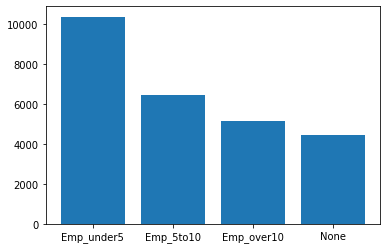

In [16]:
pltdf = train['employed_grp'].value_counts().reset_index()
plt.bar(pltdf['index'], pltdf['employed_grp'])

In [17]:
train[(train['child_num'] >= 14) | (train['family_size'] >= 9)]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,employed_grp
8462,8462,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,...,-1689,1,0,0,0,Drivers,15.0,-7.0,2.0,Emp_under5
9021,9021,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,...,-1689,1,0,0,0,Drivers,15.0,-58.0,2.0,Emp_under5
10731,10731,F,N,Y,19,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,...,-1853,1,1,1,0,Waiters/barmen staff,20.0,-5.0,2.0,Emp_5to10
25313,25313,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1649,1,1,1,0,Cleaning staff,9.0,-26.0,2.0,Emp_under5
25390,25390,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,...,-1689,1,0,0,0,Drivers,15.0,-43.0,2.0,Emp_under5
25638,25638,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1649,1,1,1,0,Cleaning staff,9.0,-31.0,2.0,Emp_under5


In [32]:
#1 outliers 제거
# 'child_num'이 14이상인 사람은 test set에 없다. 따라서 outlier 취급한다.
# 'family_size'가 9 이상인 사람은 test set에 없다. 따라서 outlier 취급한다.
train = train[(train['child_num'] < 14) & (train['family_size'] < 9)]
test = test[(test['child_num'] < 14) & (test['family_size'] < 9)]
train.shape # why 6개 안지워짐..?

(26451, 21)

In [52]:
#2 index
train_id = train['index']
test_id = test['index']

#3 target variable
train_y = train['credit']

#4 features
train_x = train.drop(['index', 'credit', 'occyp_type', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis = 1)
test_x = test.drop(['index', 'occyp_type', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis = 1)

In [36]:
#5 변수타입 정리
nm_num = ['child_num', 'income_total', 'DAYS_BIRTH', 
          'family_size', 'begin_month']
nm_str = train_x.columns.drop(nm_num)

print('categorical : ', nm_str, 
      '\n',
      'numeric :', nm_num)

categorical :  Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'work_phone', 'phone', 'email', 'employed_grp'],
      dtype='object') 
 numeric : ['child_num', 'income_total', 'DAYS_BIRTH', 'family_size', 'begin_month']


In [37]:
train_x.shape, test_x.shape

((26451, 16), (10000, 16))

### 1-2. ploting

In [138]:
# correaltion
train_x[nm_num].corr()

,child_num,income_total,DAYS_BIRTH,family_size,begin_month
child_num,1.000000,0.033442,0.343928,0.886135,-0.007353
income_total,0.033442,1.000000,0.064220,0.024458,-0.017993
DAYS_BIRTH,0.343928,0.064220,1.000000,0.303883,0.057237
family_size,0.886135,0.024458,0.303883,1.000000,-0.023426
begin_month,-0.007353,-0.017993,0.057237,-0.023426,1.000000


'family_size'와 'child_num'간 correlation이 높다. (당연한 거지만) 공선성이 발생할 우려가 있으므로 하나씩 모델에 넣어봄.

In [139]:
df = pd.concat([train_x[nm_num], train_y], axis = 1)
df[df['credit']]

,child_num,income_total,DAYS_BIRTH,family_size,begin_month,credit
0,0,202500.0,-13899,2.0,-6.0,1.0
1,1,247500.0,-11380,3.0,-5.0,1.0
2,0,450000.0,-19087,2.0,-22.0,2.0
3,0,202500.0,-15088,2.0,-37.0,0.0
4,0,157500.0,-15037,2.0,-26.0,2.0
...,...,...,...,...,...,...
26452,2,225000.0,-12079,4.0,-2.0,1.0
26453,1,180000.0,-15291,2.0,-47.0,2.0
26454,0,292500.0,-10082,2.0,-25.0,2.0
26455,0,171000.0,-10145,1.0,-59.0,2.0


### 2. scaler

In [81]:
train_x_cl = train_x.copy().reset_index()
test_x_cl = test_x.copy().reset_index()

In [83]:
test_x[nm_num].columns

Index(['child_num', 'income_total', 'DAYS_BIRTH', 'family_size',
       'begin_month'],
      dtype='object')

In [84]:
ss = StandardScaler()
train_x_cl[nm_num] = pd.DataFrame(ss.fit_transform(train_x[nm_num]), columns = train_x[nm_num].columns)
test_x_cl[nm_num] = pd.DataFrame(ss.transform(test_x[nm_num]), columns = test_x[nm_num].columns)

In [85]:
le = LabelEncoder()
for i in nm_str:
    le.fit(train_x[i])
    train_x_cl[i] = le.transform(train_x[i])
    test_x_cl[i] = le.transform(test_x[i])

In [86]:
train_x_cl.head()
type(train_x_cl)

pandas.core.frame.DataFrame

In [87]:
train_x_cl.shape

(26451, 17)

In [88]:
#train_x_cl.isnull().sum()

train_x_cl[train_x_cl['child_num'].isnull() == True]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,work_phone,phone,email,family_size,begin_month,employed_grp


In [89]:
# validation set
train_x_cl_t, train_x_cl_v, train_y_t, train_y_v = train_test_split(train_x_cl, train_y,
                 random_state = 21, test_size = 0.2)

## modeling
### 1. DecisionTree

In [91]:
train_x_cl_t[train_x_cl_t['child_num'].isnull()]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,work_phone,phone,email,family_size,begin_month,employed_grp


In [123]:
md_d1 = DecisionTreeClassifier(max_depth = 5, random_state=2021)
md_d1.fit(train_x_cl_t, train_y_t)

DecisionTreeClassifier(max_depth=5, random_state=2021)

In [124]:
pred_d1 = md_d1.predict(train_x_cl_v)

In [125]:
accuracy_score(train_y_v, pred_d1)

0.6932526932526932

In [126]:
confusion_matrix(train_y_v, pred_d1)

array([[   5,   62,  585],
       [  14,  261,  951],
       [   5,    6, 3402]], dtype=int64)

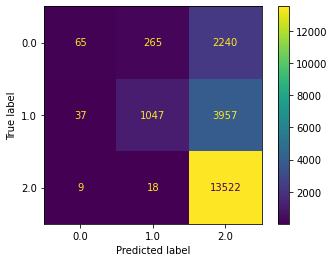

In [127]:
plot_confusion_matrix(md_d1, train_x_cl_t, train_y_t)

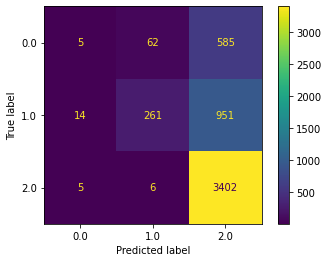

In [128]:
plot_confusion_matrix(md_d1, train_x_cl_v, train_y_v)

In [117]:
# from sklearn.tree import export_graphviz

# export_graphviz(md_d1, out_file = 'tree.dot')

In [99]:
pred_d1

array([2., 2., 2., ..., 2., 2., 2.])

### 2. RandomForest

In [100]:
md_r1 = RandomForestClassifier(n_estimators=100, 
                               random_state=2021)
md_r1.fit(train_x_cl_t, train_y_t)

RandomForestClassifier(random_state=2021)

In [101]:
pred_r1 = md_r1.predict(train_x_cl_v)

In [102]:
accuracy_score(pred_r1, train_y_v)

0.7061047061047061

### 3. Gardient Boosting

In [103]:
md_g1 = GradientBoostingClassifier(random_state=2021)
md_g1.fit(train_x_cl_t, train_y_t)

GradientBoostingClassifier(random_state=2021)

In [104]:
pred_g1 = md_g1.predict(train_x_cl_v)
accuracy_score(pred_g1, train_y_v)

0.6958986958986959

## predict test set

In [103]:
md_d2 = DecisionTreeClassifier(max_depth=2)
md_d2.fit(train_x_cl, train_y)

DecisionTreeClassifier(max_depth=2)

In [104]:
pred_d2 = md_d2.predict(test_x_cl)

In [108]:
pred_d2

array([2., 2., 2., ..., 2., 2., 2.])